In [ ]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [ ]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="/content/Data/"
else:
    PATH="/content/Data/"
os.listdir(PATH)

['train.csv', 'sample_submission.csv', 'test.csv']

In [ ]:
%%time
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

CPU times: user 842 ms, sys: 97.2 ms, total: 939 ms
Wall time: 939 ms


In [ ]:
train_df.shape, test_df.shape

((12504, 202), (11835, 201))

In [ ]:
train_df.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [ ]:
train_df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

In [ ]:
test_df.head()

ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595   

     var_7   var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.2675  2.1337  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   2.4669   
1  18.6316 -4.4131  ...  10.6165   8.8349   0.9403  10.1282  15.5765   0.4773   
2  20.2537  1.5233  ...  -0.7484  10.9935   1.9803   2.1800  12.9813   2.1281   
3  20.5660  3.3755  ...   9.5702   9.0766   1.6580   3.5813  15.1874   3.1656   
4  10.6048  2.9890  ...   4.2259   9.1723   1.2835   3.3778  19.5542  -0.2860   

   var_196  var_197  var_198  var_199  
0   4.3654  10.7200  15.4722  -8.7197  
1  -1.4852   9.8714  19.1293 -20.9760  
2  -7.1086   7.0618  19.8956 -23.1794  
3   3.9567   9.2295  13.0168  -4.2108  
4  -5.1612   7.2882  13.9260  -9.1846  

[5 rows x 201 columns]

In [ ]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:
%%time
missing_data(train_df)

CPU times: user 32.9 ms, sys: 0 ns, total: 32.9 ms
Wall time: 34 ms


ID_code target    var_0    var_1    var_2    var_3    var_4    var_5  \
Total         0      0        0        0        0        0        0        0   
Percent     0.0    0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Types    object  int64  float64  float64  float64  float64  float64  float64   

           var_6    var_7  ...   var_190   var_191   var_192   var_193  \
Total          0        0  ...         1         1         1         1   
Percent      0.0      0.0  ...  0.007997  0.007997  0.007997  0.007997   
Types    float64  float64  ...   float64   float64   float64   float64   

          var_194   var_195   var_196   var_197   var_198   var_199  
Total           1         1         1         1         1         1  
Percent  0.007997  0.007997  0.007997  0.007997  0.007997  0.007997  
Types     float64   float64   float64   float64   float64   float64  

[3 rows x 202 columns]

In [ ]:
%%time
missing_data(test_df)

CPU times: user 42.7 ms, sys: 0 ns, total: 42.7 ms
Wall time: 54.7 ms


ID_code    var_0    var_1    var_2    var_3    var_4    var_5  \
Total         0        0        0        0        0        0        0   
Percent     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Types    object  float64  float64  float64  float64  float64  float64   

           var_6    var_7    var_8  ...  var_190  var_191  var_192  var_193  \
Total          0        0        0  ...        1        1        1        1   
Percent      0.0      0.0      0.0  ...  0.00845  0.00845  0.00845  0.00845   
Types    float64  float64  float64  ...  float64  float64  float64  float64   

         var_194  var_195  var_196  var_197  var_198  var_199  
Total          1        1        1        1        1        1  
Percent  0.00845  0.00845  0.00845  0.00845  0.00845  0.00845  
Types    float64  float64  float64  float64  float64  float64  

[3 rows x 201 columns]

In [ ]:
%%time
train_df.describe()

CPU times: user 886 ms, sys: 13.8 ms, total: 900 ms
Wall time: 938 ms


target         var_0         var_1         var_2         var_3  \
count  12504.000000  12504.000000  12504.000000  12504.000000  12504.000000   
mean       0.098369     10.666481     -1.624035     10.697642      6.802232   
std        0.297824      3.050106      4.068154      2.631323      2.049344   
min        0.000000      0.597900    -13.422700      3.309000      0.937700   
25%        0.000000      8.445675     -4.770875      8.720600      5.264400   
50%        0.000000     10.514500     -1.592450     10.534350      6.837000   
75%        0.000000     12.739625      1.346625     12.488675      8.342675   
max        1.000000     19.289300      8.584900     18.347700     12.977300   

              var_4         var_5         var_6         var_7         var_8  \
count  12504.000000  12504.000000  12504.000000  12504.000000  12504.000000   
mean      11.084534     -5.089444      5.401214     16.602287      0.297424   
std        1.619909      7.834568      0.868896      3.427177      3.297133   
min        5.943000    -29.013300      2.673300      7.642200     -9.991100   
25%        9.882000    -11.208700      4.762525     13.989675     -2.257275   
50%       11.100200     -4.905700      5.377550     16.560450      0.351300   
75%       12.274725      0.936225      5.998775     19.141025      2.908350   
max       15.366400     17.251600      7.875500     26.965600      9.103800   

       ...       var_190       var_191       var_192       var_193  \
count  ...  12503.000000  12503.000000  12503.000000  12503.000000   
mean   ...      3.219602      7.443639      1.934790      3.313362   
std    ...      4.571498      3.036398      1.470775      3.997969   
min    ...    -11.695300     -2.343000     -3.515900    -10.094200   
25%    ...     -0.090900      5.142600      0.912500      0.576700   
50%    ...      3.264000      7.333500      1.926000      3.374500   
75%    ...      6.411450      9.527950      2.948250      6.179000   
max    ...     16.614400     16.398500      7.139000     16.782600   

            var_194       var_195       var_196       var_197       var_198  \
count  12503.000000  12503.000000  12503.000000  12503.000000  12503.000000   
mean      18.011223     -0.172413      2.269442      8.915122     15.877759   
std        3.178726      1.414861      5.430755      0.917958      3.013443   
min       10.387000     -4.488300    -12.325500      6.245200      7.233700   
25%       15.605200     -1.201350     -1.976200      8.262650     13.832950   
50%       17.951200     -0.204200      2.438400      8.895400     15.909600   
75%       20.471300      0.786900      6.481950      9.605400     18.088700   
max       27.485800      3.555400     18.321500     11.843900     25.442200   

            var_199  
count  12503.000000  
mean      -3.437998  
std       10.437905  
min      -36.302500  
25%      -11.392250  
50%       -2.934000  
75%        4.653200  
max       25.831600  

[8 rows x 201 columns]

In [ ]:
%time
test_df.describe()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


var_0         var_1         var_2         var_3         var_4  \
count  11835.000000  11835.000000  11835.000000  11835.000000  11835.000000   
mean      10.670461     -1.628657     10.688976      6.781857     11.072073   
std        3.054719      4.083809      2.612450      2.059733      1.625056   
min        1.578200    -13.378500      2.516400      0.954400      5.989200   
25%        8.407100     -4.698900      8.742350      5.210800      9.865750   
50%       10.542100     -1.631100     10.566300      6.808600     11.090600   
75%       12.750100      1.326600     12.447000      8.351250     12.269350   
max       20.064900      9.023900     18.277200     12.837200     15.432900   

              var_5         var_6         var_7         var_8         var_9  \
count  11835.000000  11835.000000  11835.000000  11835.000000  11835.000000   
mean      -5.039878      5.422164     16.498670      0.268878      7.568939   
std        7.921443      0.868189      3.424412      3.343043      1.231495   
min      -27.098300      2.314800      6.652900     -8.919400      4.257900   
25%      -11.256450      4.780450     13.870450     -2.304350      6.627500   
50%       -4.835100      5.390400     16.398400      0.320300      7.636600   
75%        1.017450      6.014200     19.087150      2.934100      8.592400   
max       15.999800      8.021300     27.856800      8.663600     11.003600   

       ...       var_190       var_191       var_192       var_193  \
count  ...  11834.000000  11834.000000  11834.000000  11834.000000   
mean   ...      3.214024      7.465796      1.961526      3.324811   
std    ...      4.579799      3.019821      1.475675      3.997530   
min    ...    -12.900200     -1.295600     -3.340900    -10.697200   
25%    ...     -0.115925      5.184825      0.942950      0.556975   
50%    ...      3.138100      7.372200      1.936550      3.474500   
75%    ...      6.390400      9.505850      2.984975      6.166175   
max    ...     18.479400     16.355900      7.213700     16.241500   

            var_194       var_195       var_196       var_197       var_198  \
count  11834.000000  11834.000000  11834.000000  11834.000000  11834.000000   
mean      18.021501     -0.125173      2.376314      8.912123     15.872431   
std        3.154062      1.433450      5.460569      0.919689      3.013516   
min        9.472600     -4.516700    -13.251900      6.218200      7.311400   
25%       15.646375     -1.158775     -1.874800      8.260000     13.804125   
50%       18.012550     -0.166000      2.521800      8.888700     15.950100   
75%       20.437275      0.848225      6.628300      9.583300     18.081775   
max       27.011700      4.255700     15.680400     11.559100     24.845300   

            var_199  
count  11834.000000  
mean      -3.279693  
std       10.411777  
min      -39.457800  
25%      -11.085750  
50%       -2.766250  
75%        4.953225  
max       24.027500  

[8 rows x 200 columns]

In [ ]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

In [30]:
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

There are 9.836852207293665% target values with 1


In [31]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 640x480 with 0 Axes>

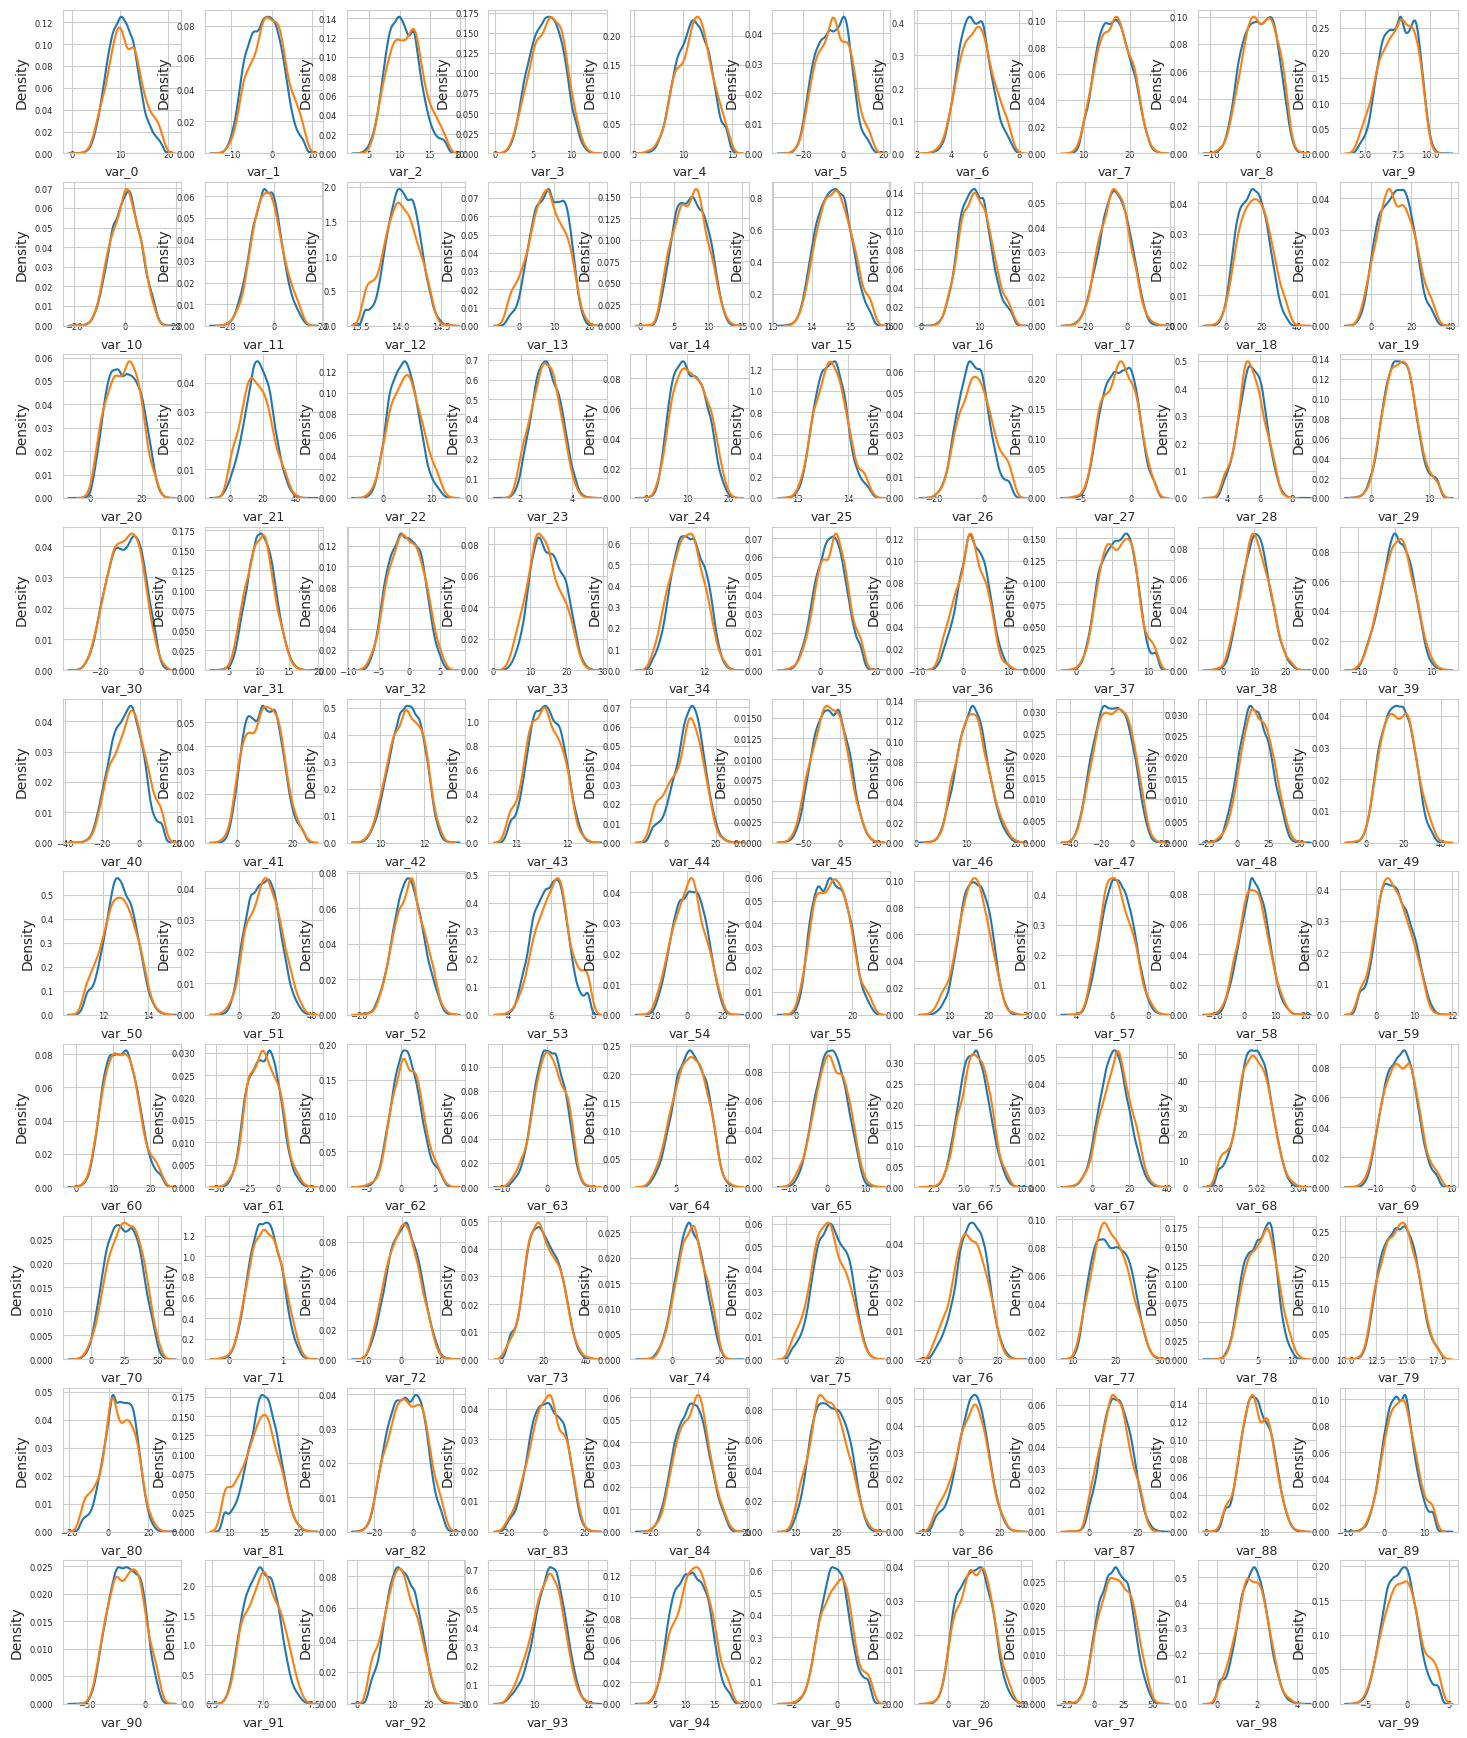

In [32]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 640x480 with 0 Axes>

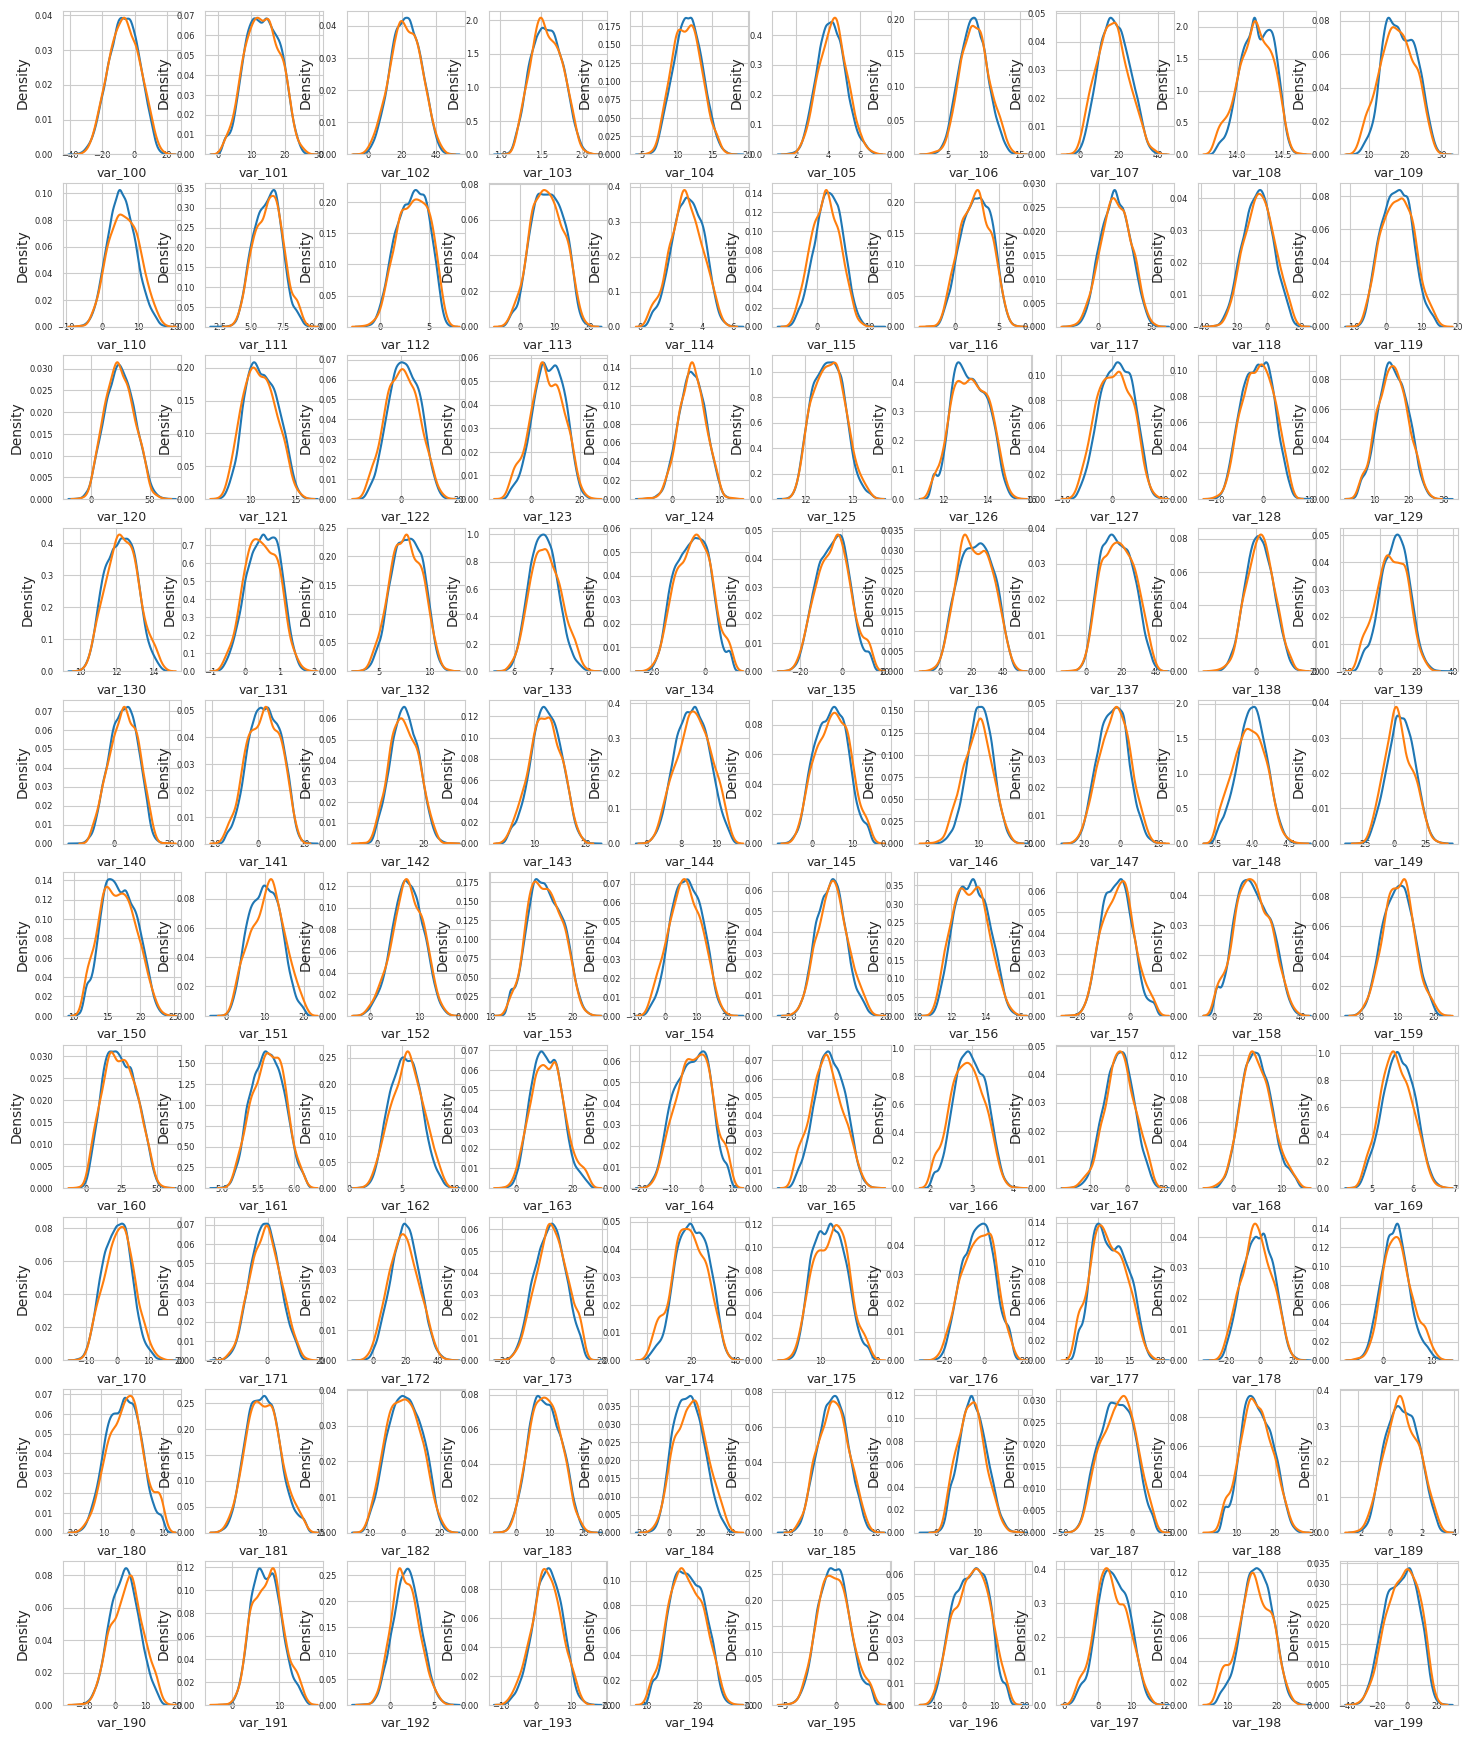

In [33]:
features = train_df.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 640x480 with 0 Axes>

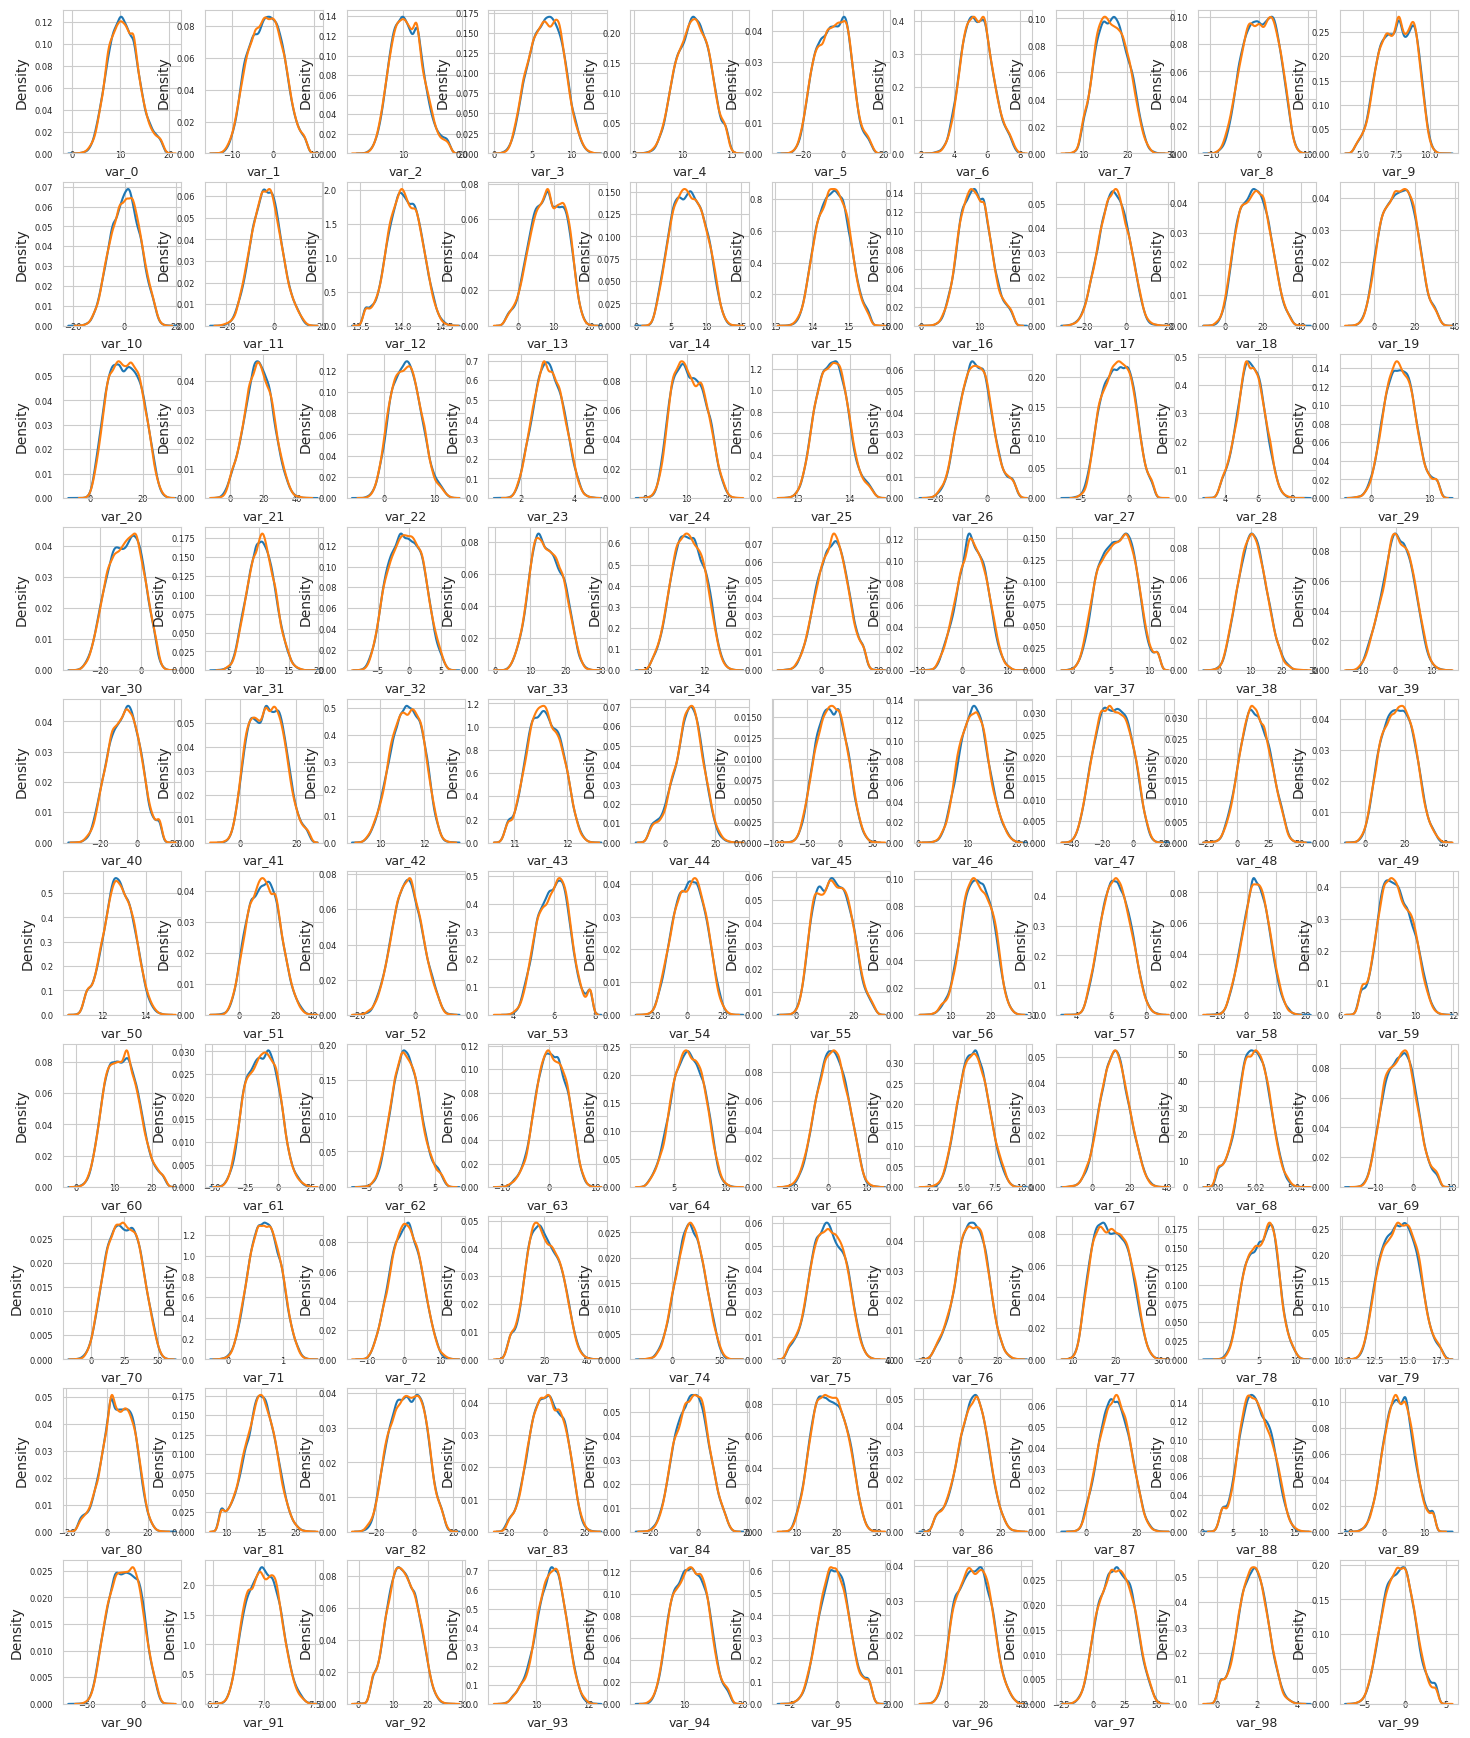

In [34]:
features = train_df.columns.values[2:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

<Figure size 640x480 with 0 Axes>

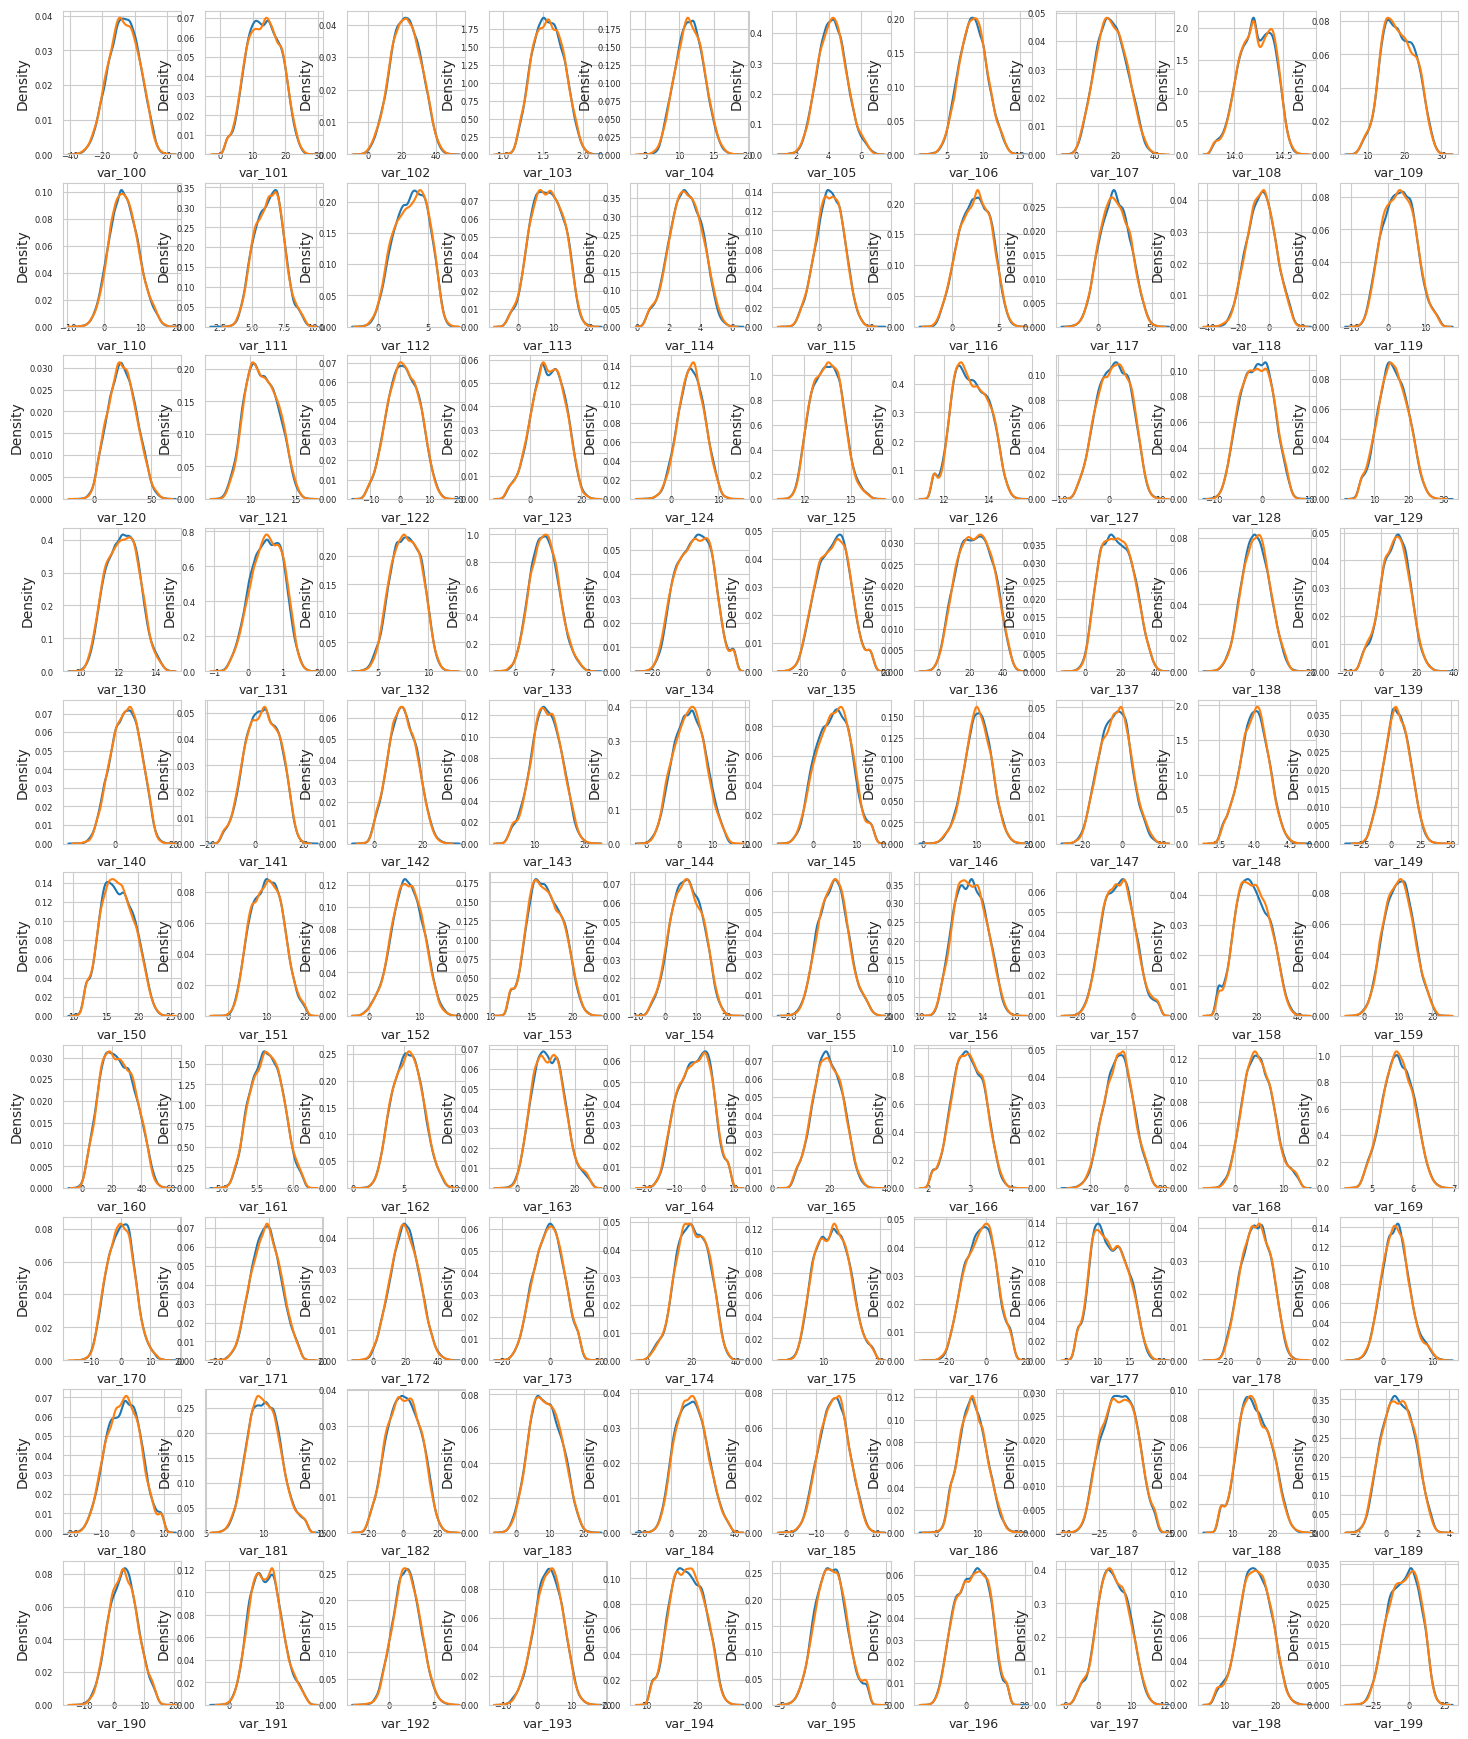

In [35]:
features = train_df.columns.values[102:202]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

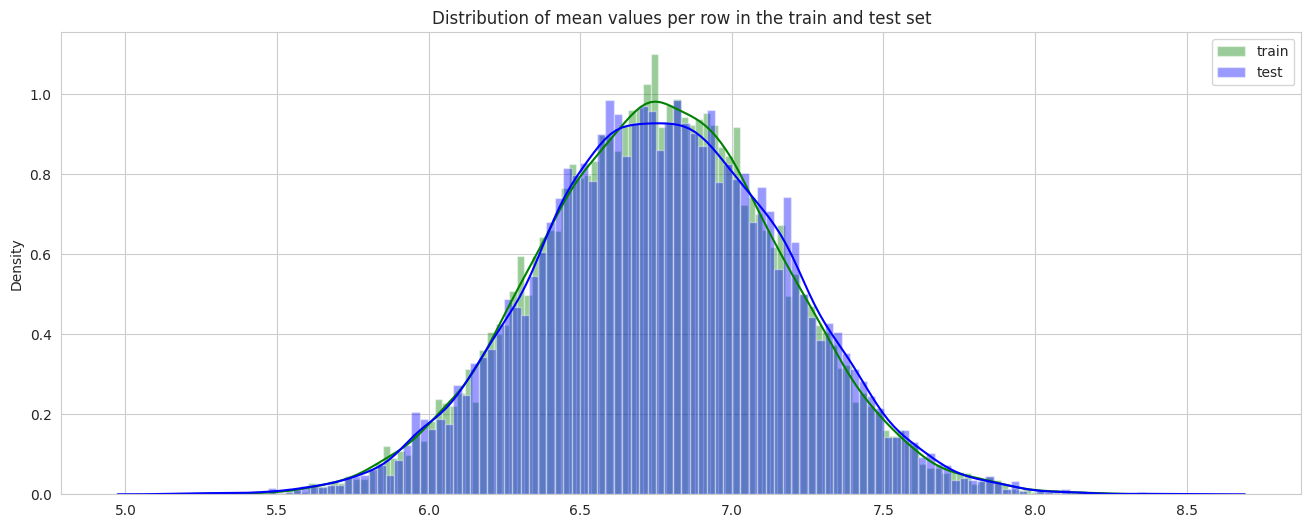

In [36]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

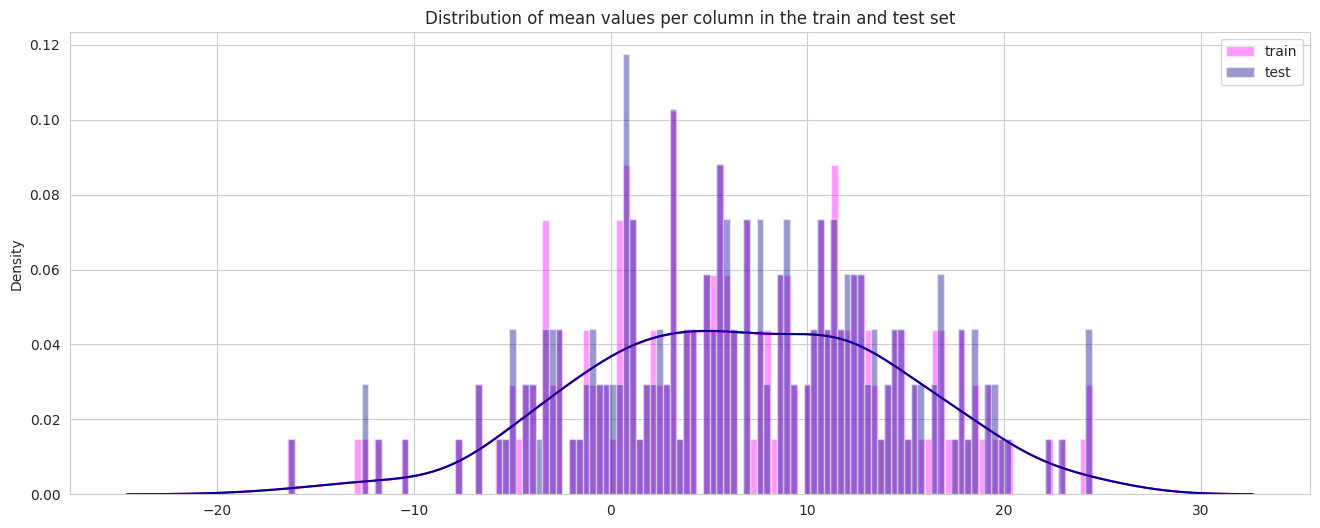

In [37]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

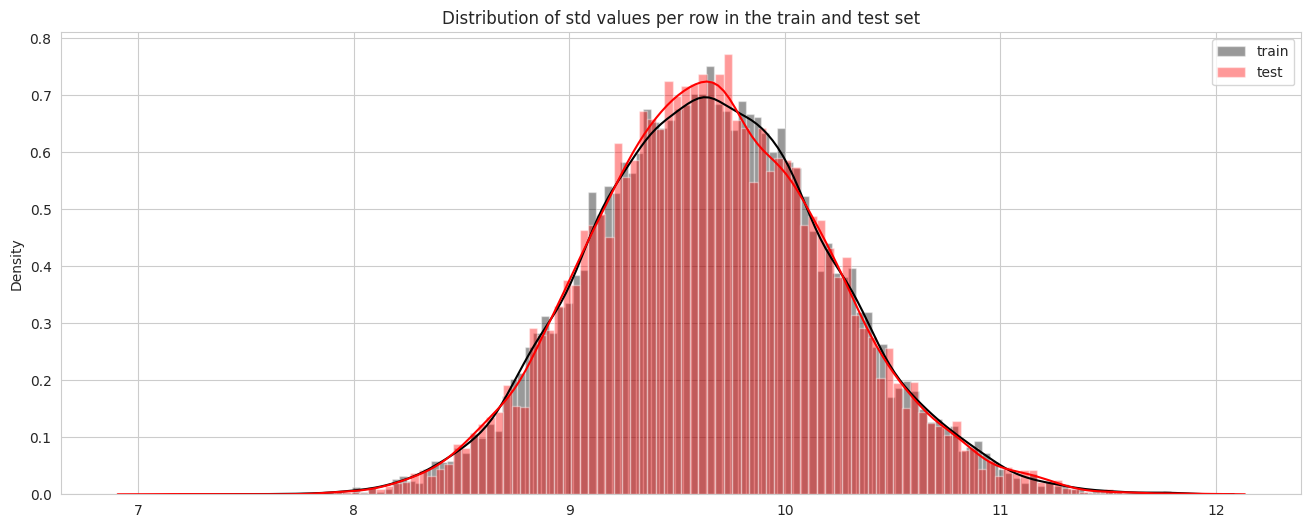

In [38]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

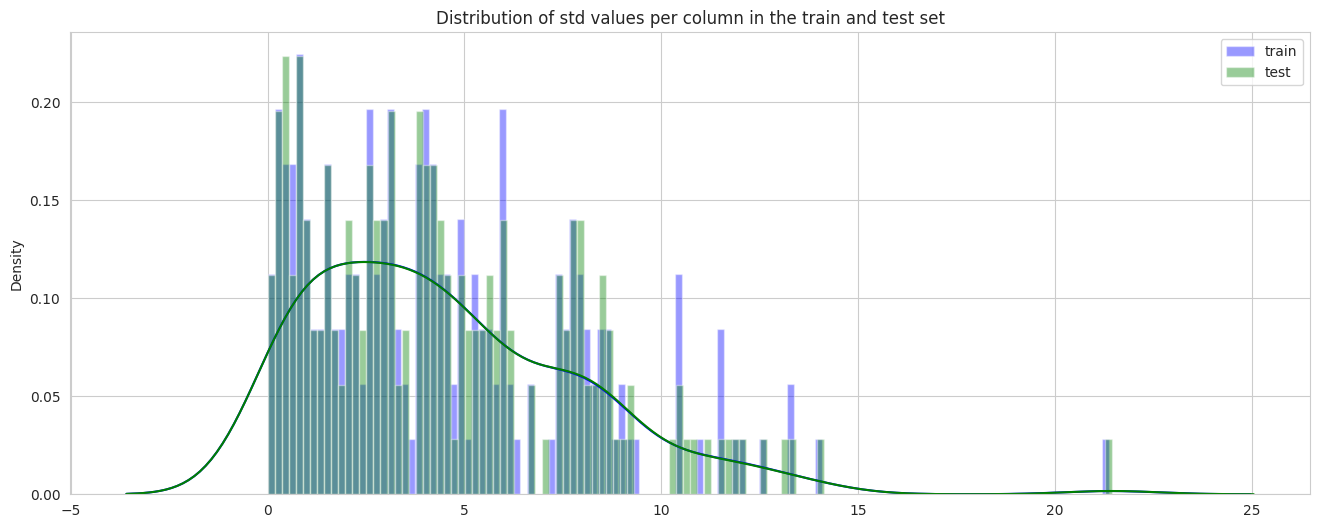

In [39]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

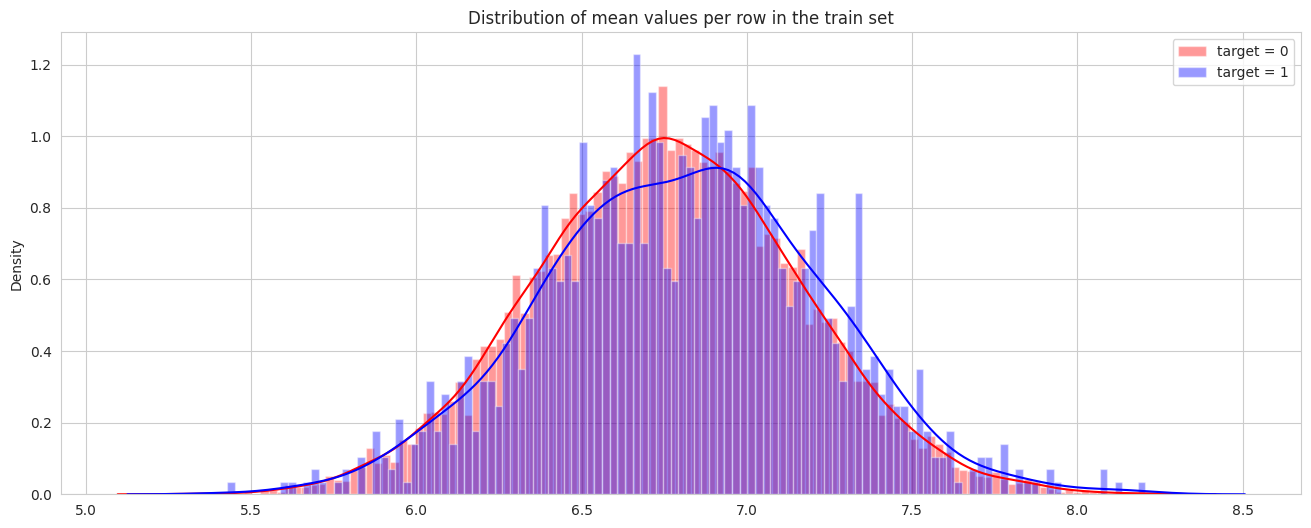

In [40]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

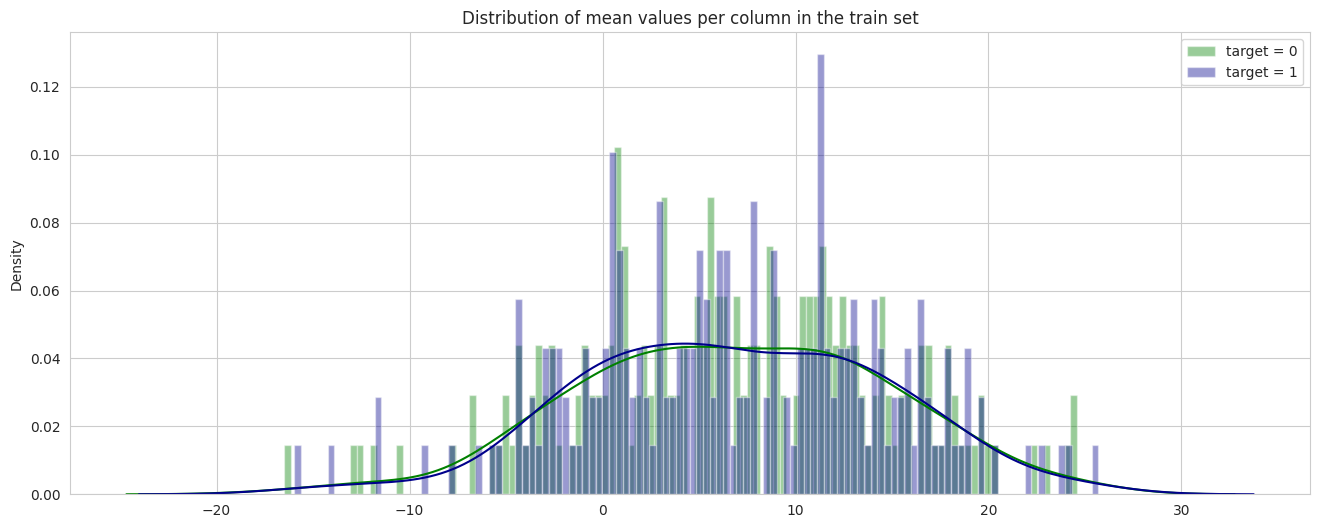

In [41]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

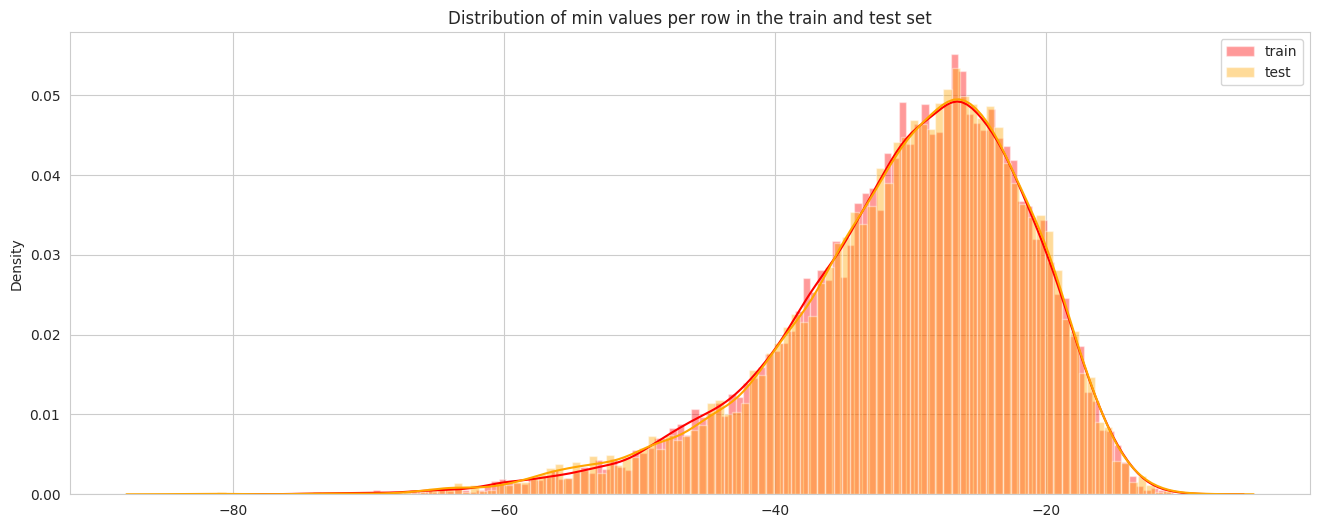

In [42]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train_df[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

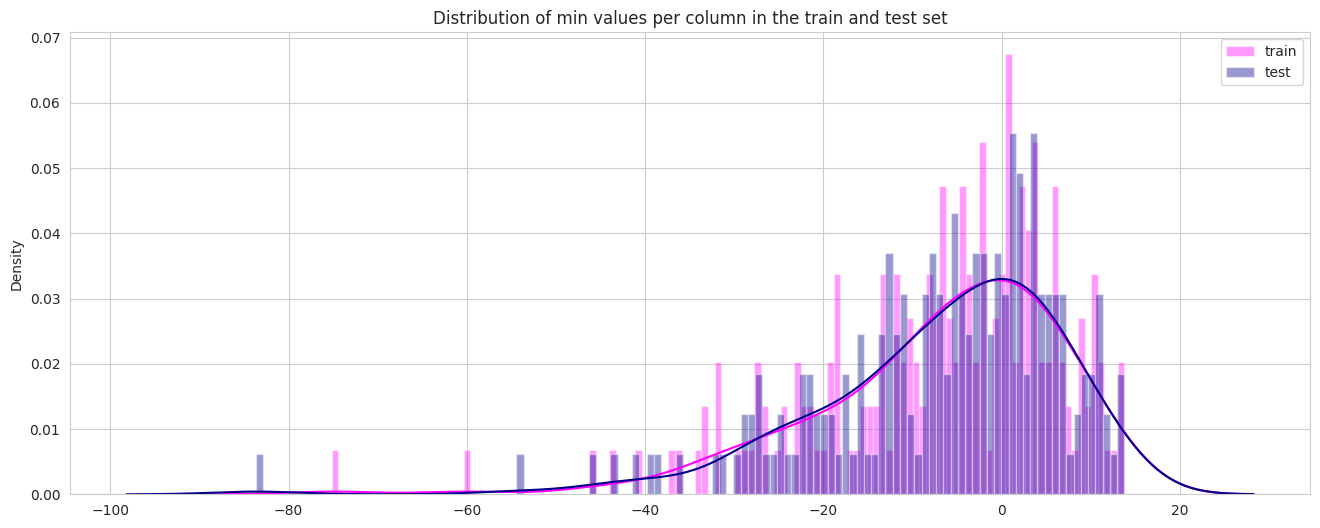

In [43]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train_df[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

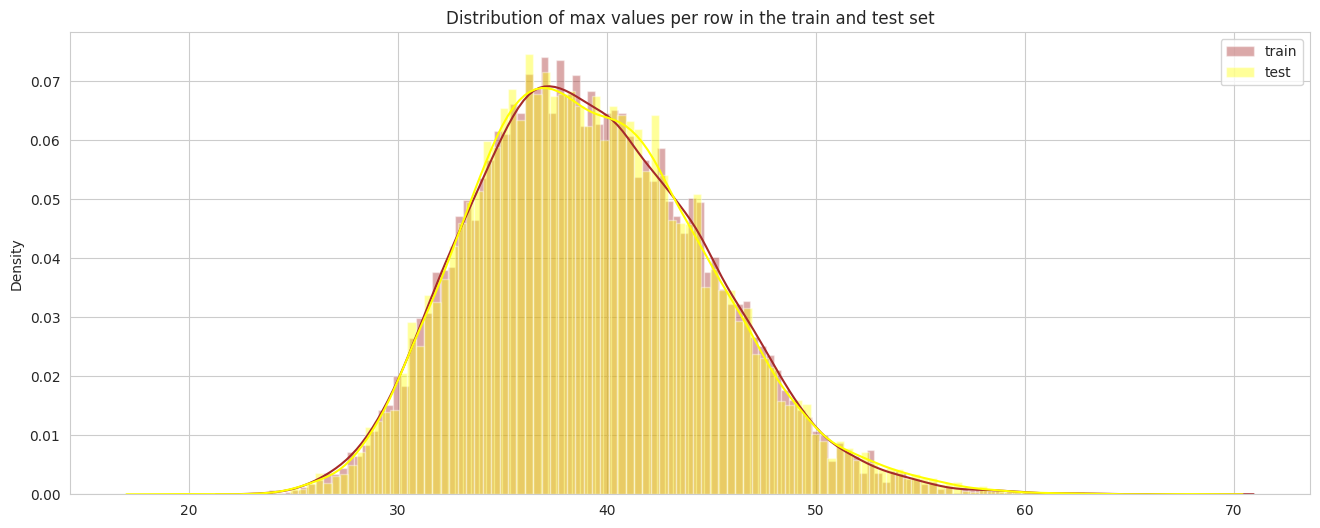

In [44]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train_df[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

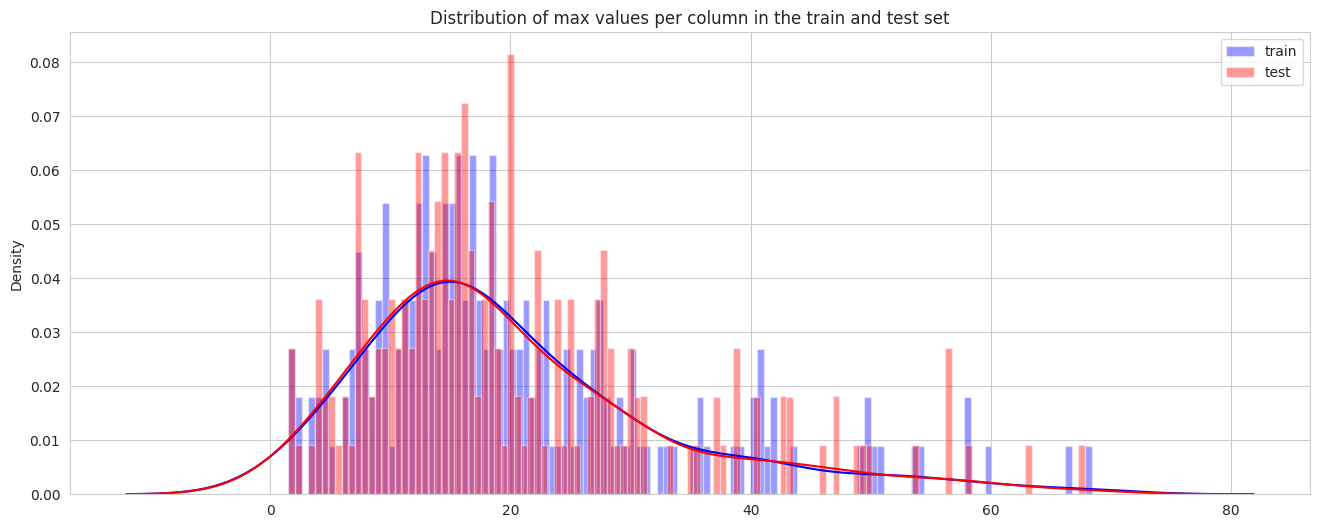

In [45]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train_df[features].max(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

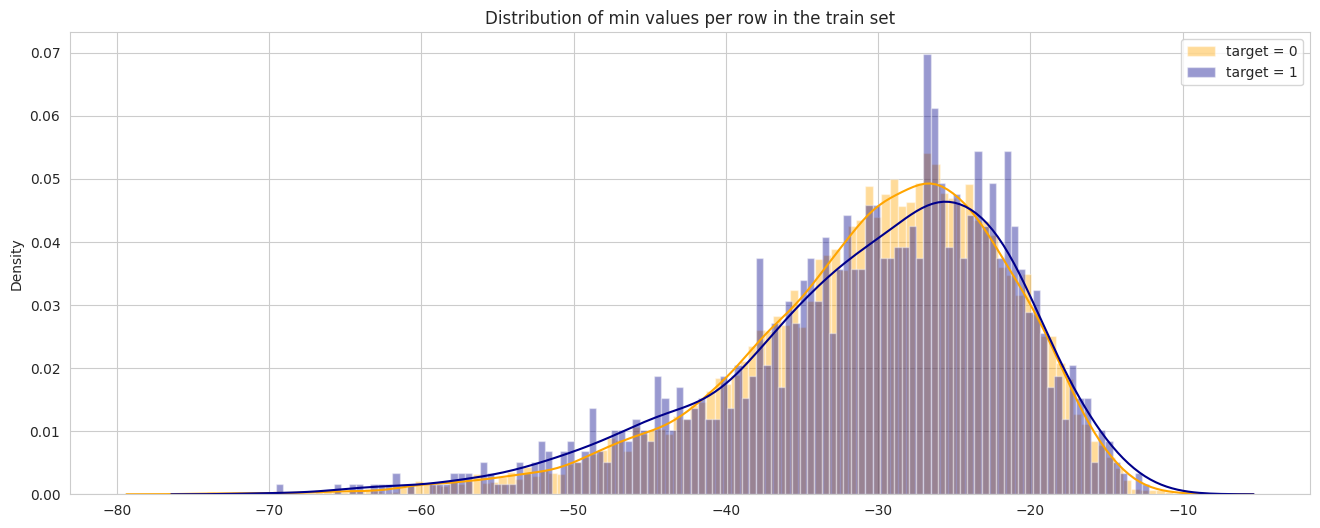

In [46]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

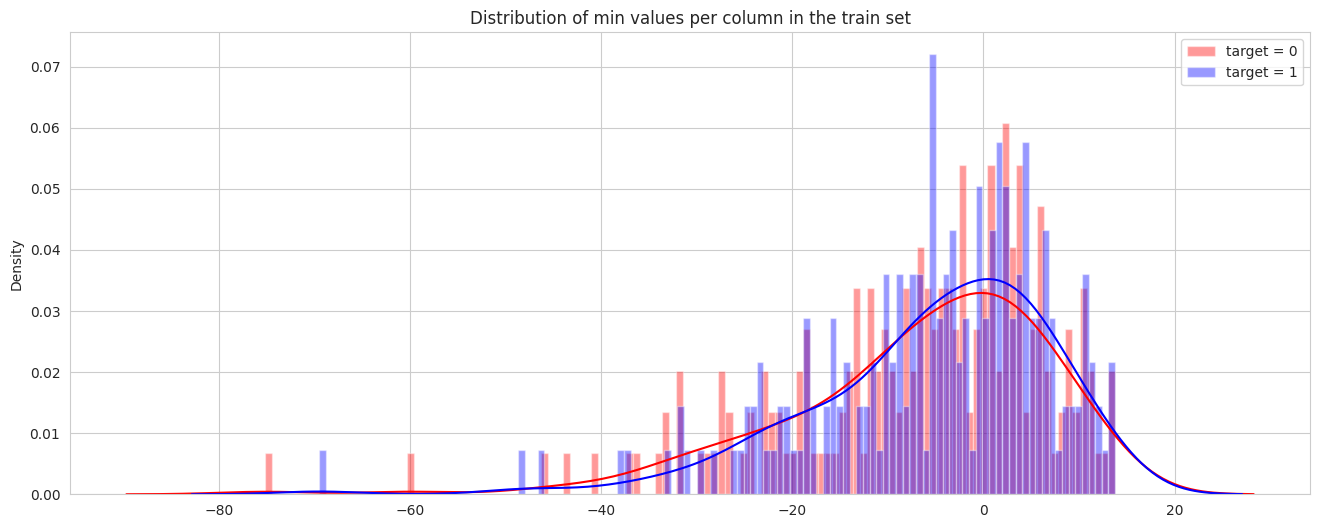

In [47]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

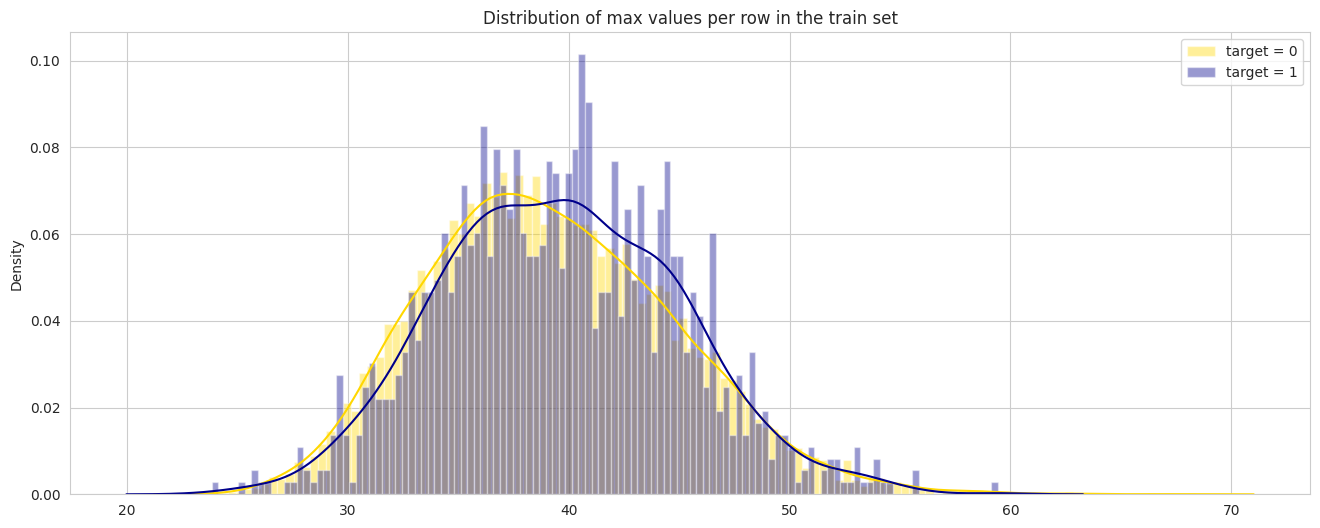

In [48]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

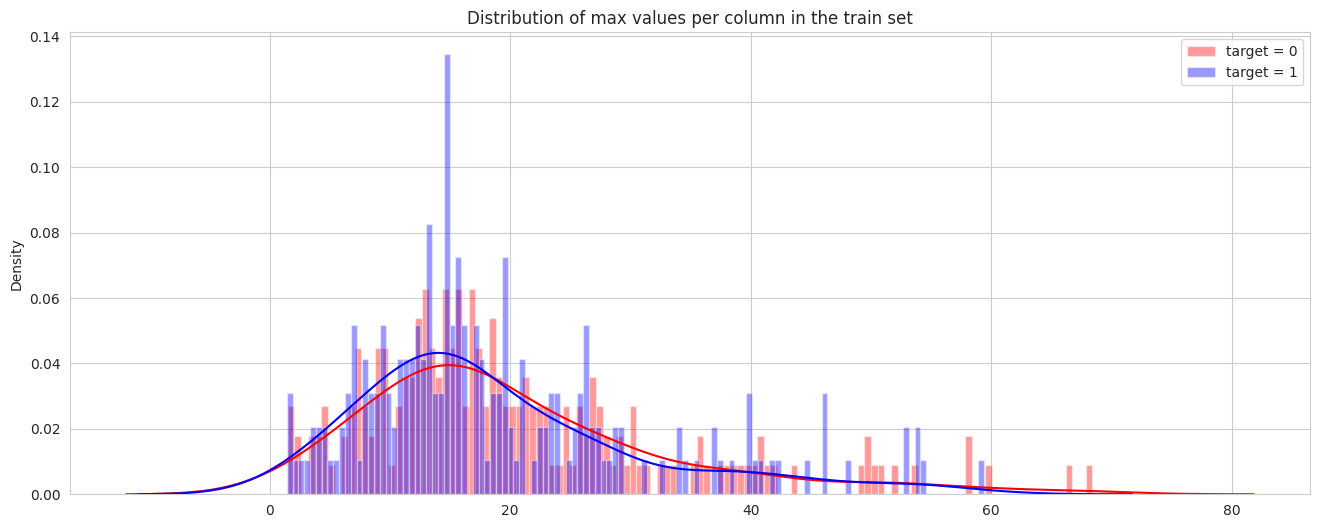

In [49]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

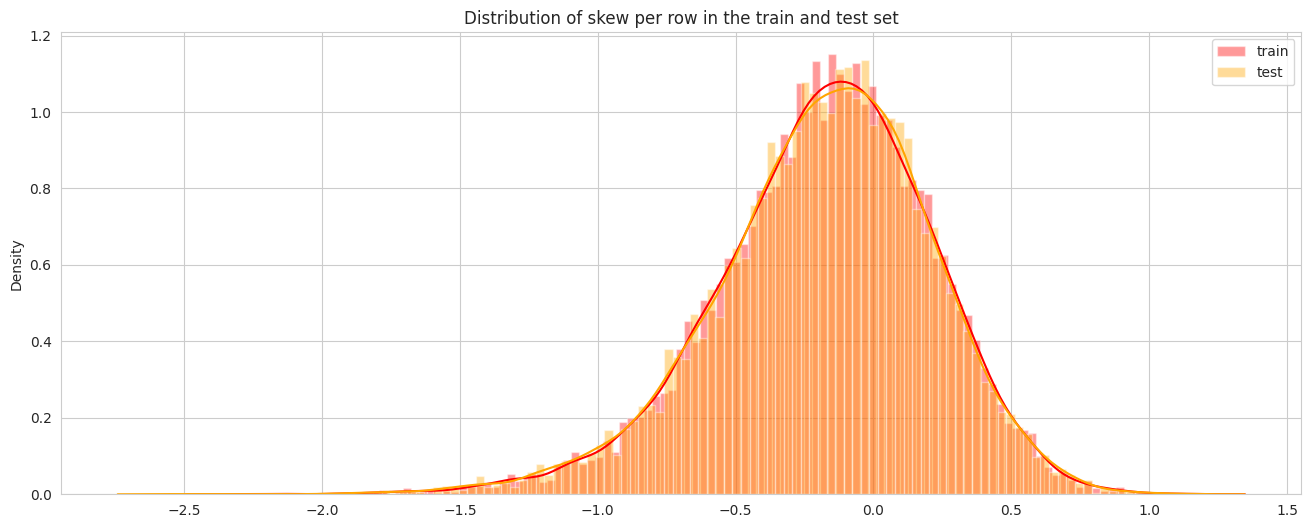

In [50]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

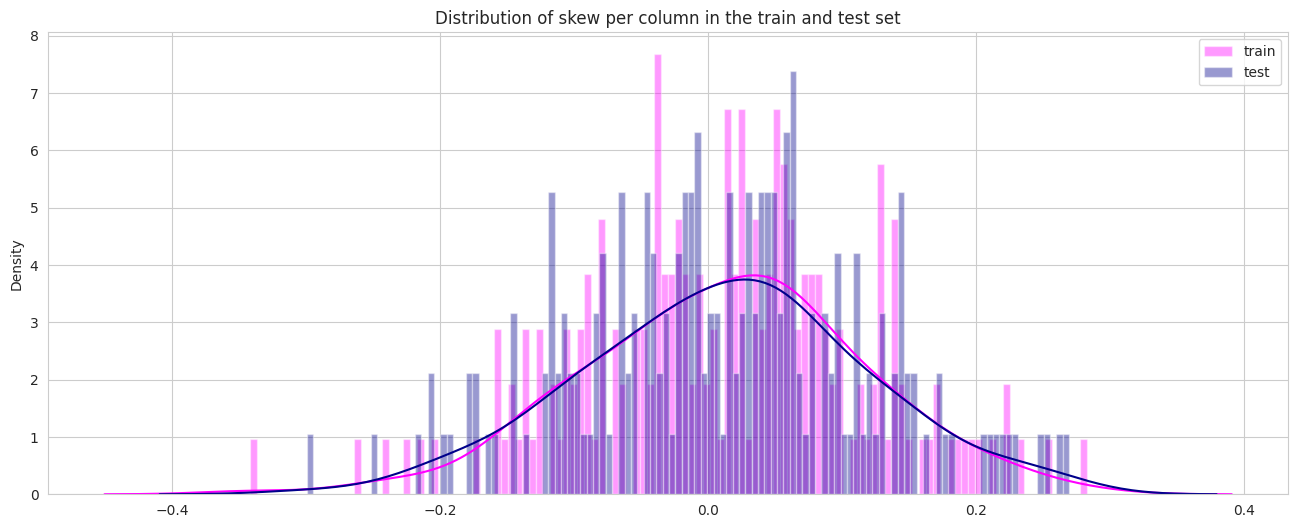

In [51]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train_df[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

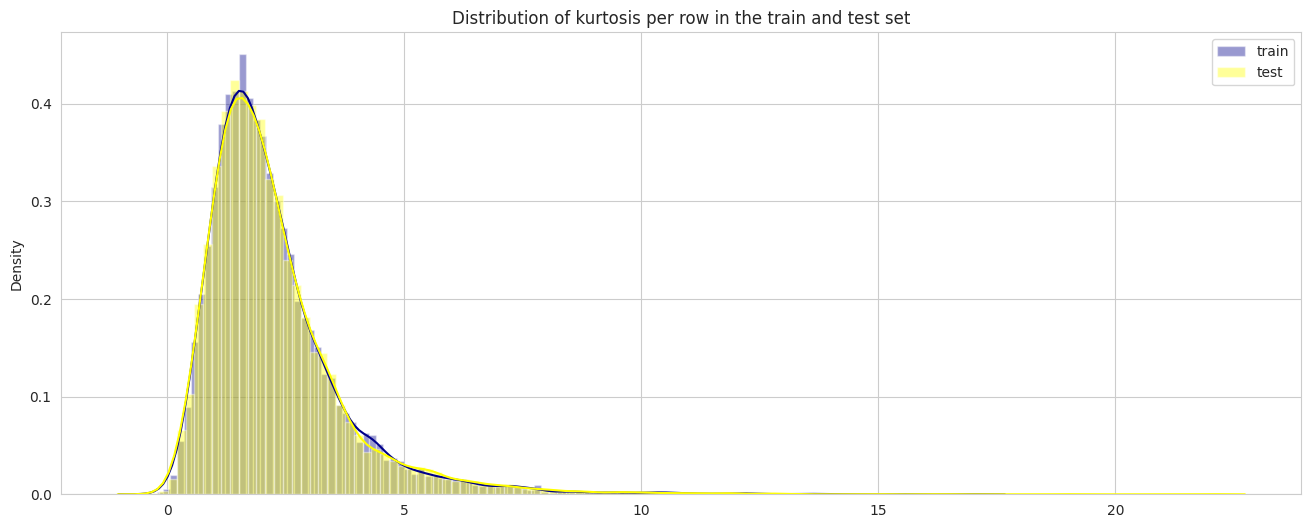

In [52]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

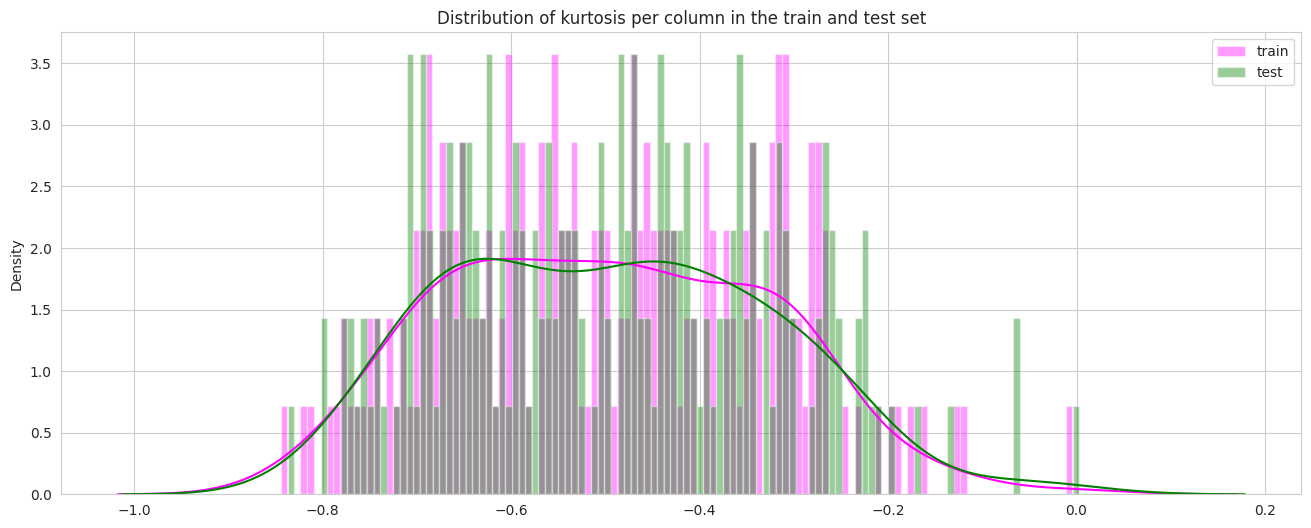

In [53]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

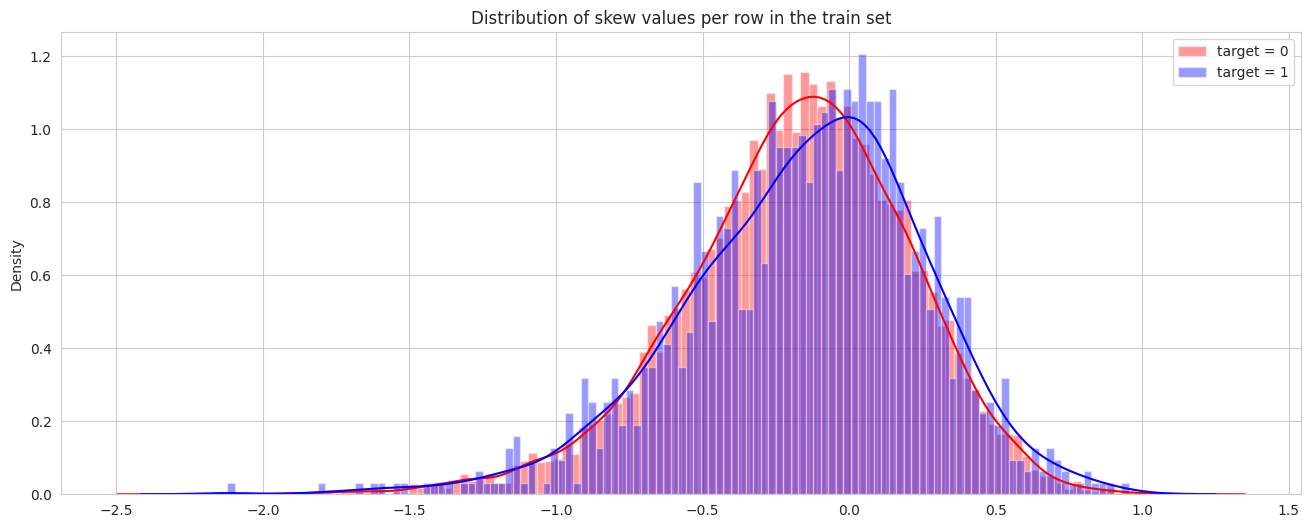

In [54]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

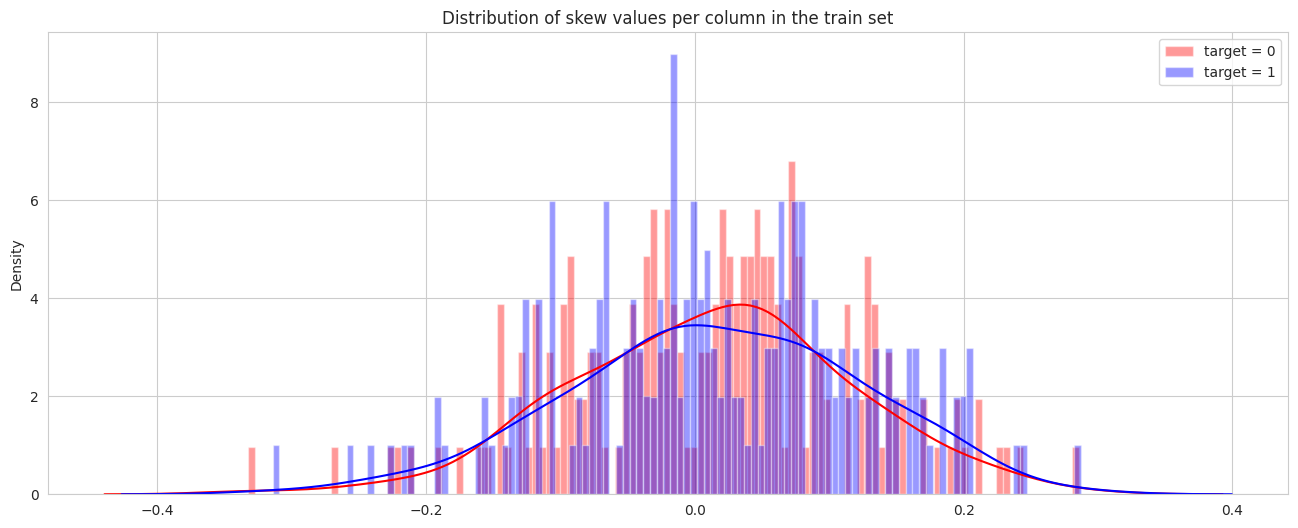

In [55]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

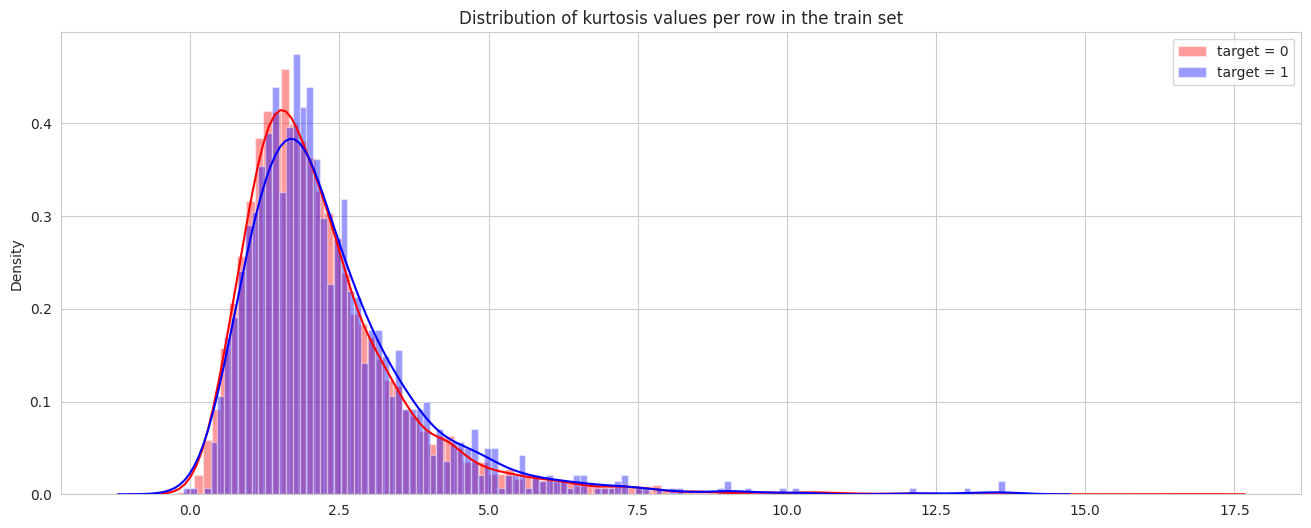

In [56]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

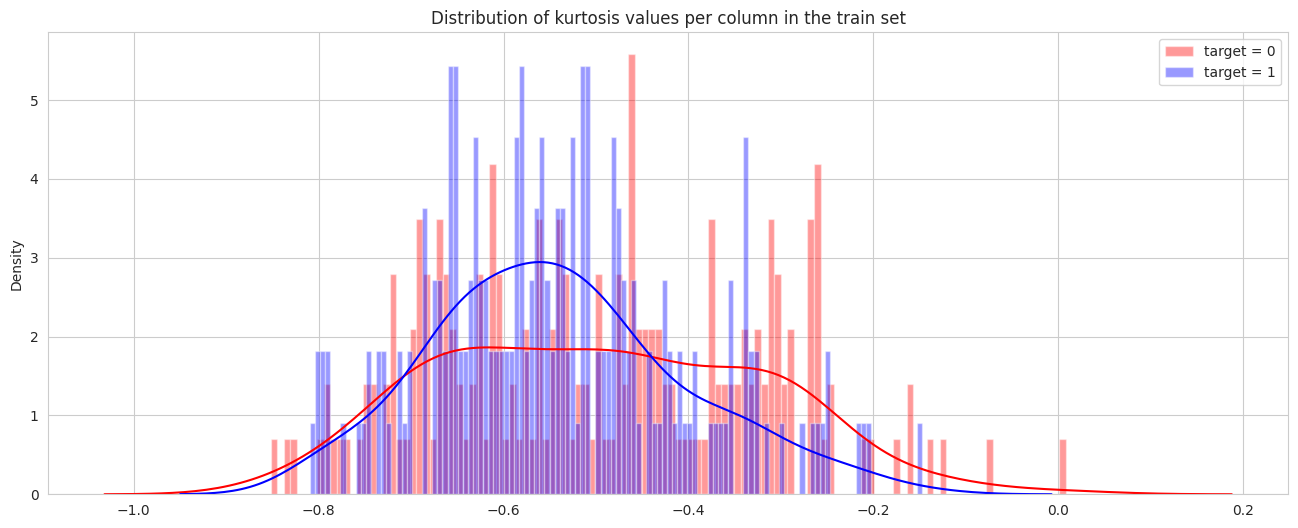

In [57]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

In [58]:
%%time
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

CPU times: user 1.4 s, sys: 8.99 ms, total: 1.41 s
Wall time: 1.4 s


level_0  level_1             0
0  var_155   var_68  3.102038e-07
1   var_68  var_155  3.102038e-07
2   var_85   var_36  9.393372e-07
3   var_36   var_85  9.393372e-07
4   var_31   var_54  1.098971e-06
5   var_54   var_31  1.098971e-06
6  var_117   var_46  1.164512e-06
7   var_46  var_117  1.164512e-06
8   var_49   var_46  2.741814e-06
9   var_46   var_49  2.741814e-06

In [59]:
correlations.tail(10)

level_0  level_1         0
39790  var_183   var_20  0.034266
39791   var_20  var_183  0.034266
39792   var_63  var_119  0.034406
39793  var_119   var_63  0.034406
39794   var_85  var_133  0.034707
39795  var_133   var_85  0.034707
39796  var_174  var_159  0.035327
39797  var_159  var_174  0.035327
39798    var_2  var_162  0.038941
39799  var_162    var_2  0.038941

In [60]:
correlations.head(10)

level_0  level_1             0
0  var_155   var_68  3.102038e-07
1   var_68  var_155  3.102038e-07
2   var_85   var_36  9.393372e-07
3   var_36   var_85  9.393372e-07
4   var_31   var_54  1.098971e-06
5   var_54   var_31  1.098971e-06
6  var_117   var_46  1.164512e-06
7   var_46  var_117  1.164512e-06
8   var_49   var_46  2.741814e-06
9   var_46   var_49  2.741814e-06

In [61]:
%%time
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

CPU times: user 794 ms, sys: 308 µs, total: 795 ms
Wall time: 824 ms


In [62]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

68       126      108      12       161     91       103  \
Feature         var_68  var_126  var_108   var_12  var_161  var_91  var_103   
Max duplicates      82       20       20       19       11      11        9   
Value           5.0177  11.5353  14.1997  13.5545   5.6173  6.9559   1.4922   

                    148      25       43       133      125      131     71   \
Feature         var_148   var_25   var_43  var_133  var_125  var_131  var_71   
Max duplicates        9        8        8        8        8        7       7   
Value            3.8795  13.4596  11.6748   6.7955  12.7622   0.5503    0.45   

                    15   
Feature          var_15  
Max duplicates        7  
Value           14.4314

In [63]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

68       108      126      12      91       103      161  \
Feature         var_68  var_108  var_126   var_12  var_91  var_103  var_161   
Max duplicates      84       19       17       12      10        9        9   
Value           5.0196  14.2002  11.5356  14.0307  7.1058   1.4603   5.5558   

                   71       148      25      23       125      131      43   \
Feature         var_71  var_148   var_25  var_23  var_125  var_131   var_43   
Max duplicates       9        9        8       8        8        8        8   
Value           0.6188   4.1419  13.4835   2.767  12.3986   0.3639  11.4915   

                    15   
Feature          var_15  
Max duplicates        7  
Value           14.4797

In [64]:
%%time
idx = features = train_df.columns.values[2:202]
for df in [test_df, train_df]:
    df['sum'] = df[idx].sum(axis=1)
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

CPU times: user 810 ms, sys: 204 ms, total: 1.01 s
Wall time: 1.11 s


In [65]:
train_df[train_df.columns[202:]].head()

sum      min      max      mean        std      skew      kurt  \
0  1456.3182 -21.4494  43.1127  7.281591   9.331540  0.101580  1.331023   
1  1415.3636 -47.3797  40.5632  7.076818  10.336130 -0.351734  4.110215   
2  1240.8966 -22.4038  33.8820  6.204483   8.753387 -0.056957  0.546438   
3  1288.2319 -35.1659  38.1015  6.441160   9.594064 -0.480116  2.630499   
4  1354.2310 -65.4863  41.1037  6.771155  11.287122 -1.463426  9.787399   

       med  
0  6.77040  
1  7.22315  
2  5.89940  
3  6.70260  
4  6.94735

In [66]:
test_df[test_df.columns[201:]].head()

sum      min      max      mean        std      skew      kurt  \
0  1416.6404 -31.9891  42.0248  7.083202   9.910632 -0.088518  1.871262   
1  1249.6860 -41.1924  35.6020  6.248430   9.541267 -0.559785  3.391068   
2  1430.2599 -34.3488  39.3654  7.151300   9.967466 -0.135084  2.326901   
3  1411.4447 -21.4797  40.3383  7.057224   8.257204 -0.167741  2.253054   
4  1423.7364 -24.8254  45.5510  7.118682  10.043542  0.293484  2.044943   

       med  
0  7.31440  
1  6.43960  
2  7.26355  
3  6.89675  
4  6.83375

In [67]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 640x480 with 0 Axes>

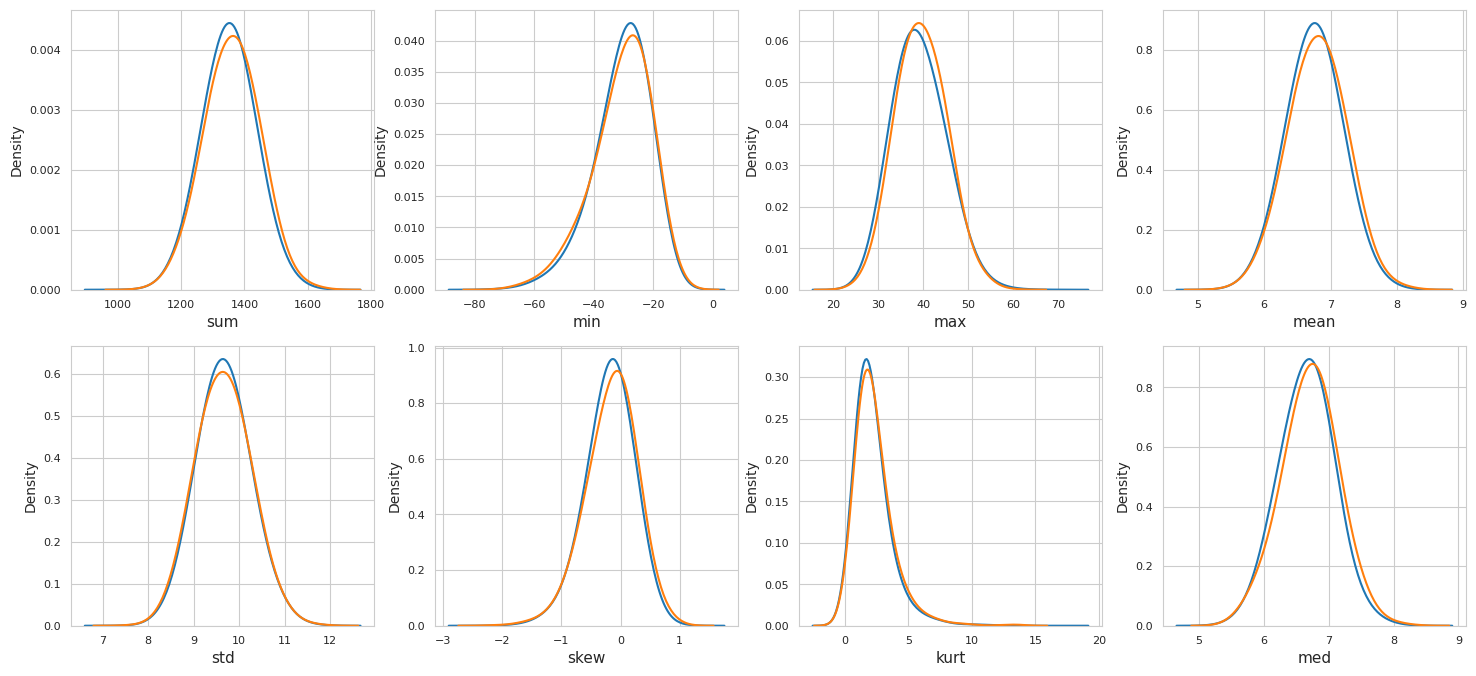

In [68]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

<Figure size 640x480 with 0 Axes>

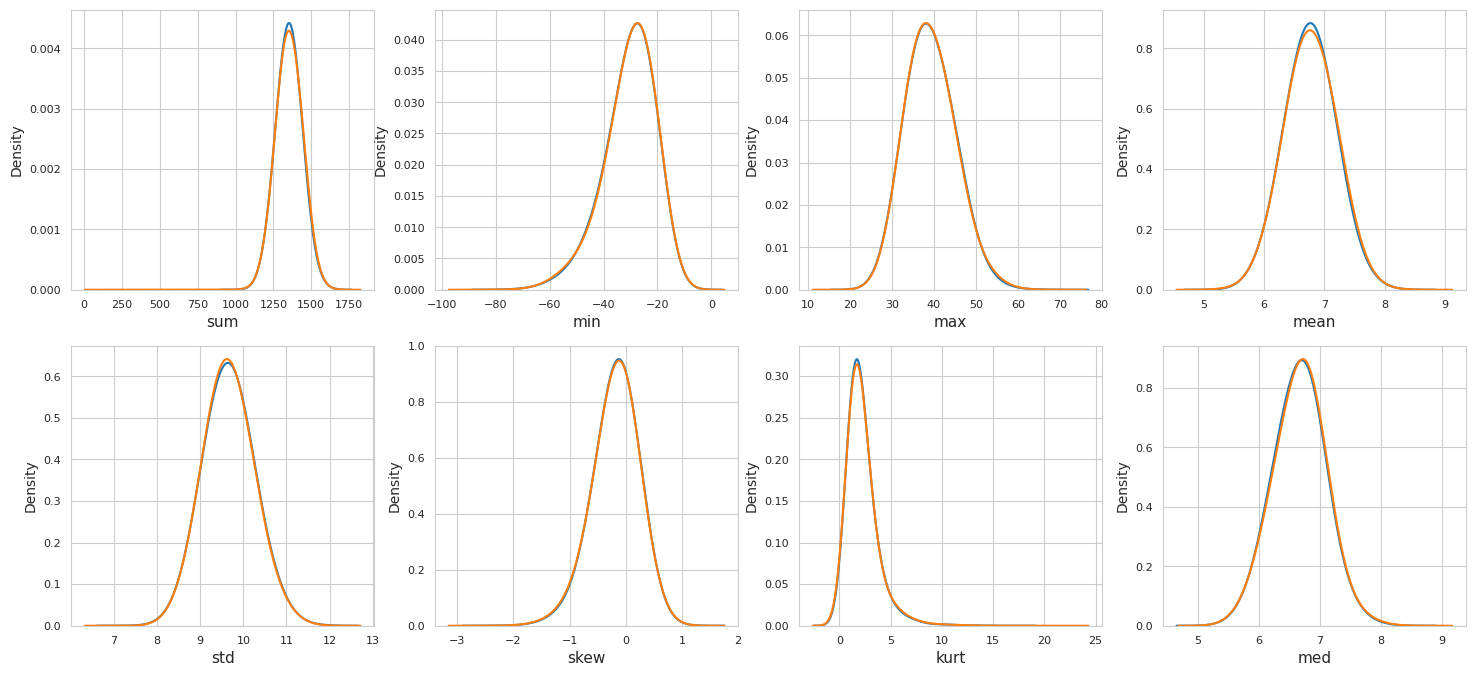

In [69]:
features = train_df.columns.values[202:]
plot_new_feature_distribution(train_df, test_df, 'train', 'test', features)

In [70]:
print('Train and test columns: {} {}'.format(len(train_df.columns), len(test_df.columns)))

Train and test columns: 210 209
